# TinyTimeMixer (TTM) using single dataset - ETTm1



In [1]:
# Install the tsfm library
# ! pip install "granite-tsfm[notebooks] @ git+https://github.com/ibm-granite/granite-tsfm.git@v0.2.22"

## Imports

In [1]:
import math
import os
import tempfile

import pandas as pd
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from transformers import EarlyStoppingCallback, Trainer, TrainingArguments, set_seed
from transformers.integrations import INTEGRATION_TO_CALLBACK
from sklearn.metrics import mean_squared_error
import numpy as np
import pickle

from tsfm_public import TimeSeriesPreprocessor, TrackingCallback, count_parameters, get_datasets, TinyTimeMixerForPrediction
from tsfm_public.toolkit.get_model import get_model
from tsfm_public.toolkit.lr_finder import optimal_lr_finder
from tsfm_public.toolkit.visualization import plot_predictions
import matplotlib.pyplot as plt

In [2]:
import warnings


# Suppress all warnings
warnings.filterwarnings("ignore")

### Helper functions

In [45]:
# function for comparing the predicted values with actual values at a particular point in time (For ex: At 12/24/48 hrs from current time...)

def compare_forecast(forecast, date_col, prediction_col, actual_col, hours_out):

  comparisons = pd.DataFrame()
  comparisons[date_col] = forecast[date_col]
  actual = []
  pred = []

  for i in range(len(forecast)):
    pred.append(forecast[prediction_col].values[i][hours_out - 1]) # prediction for next day
    actual.append(forecast[actual_col].values[i][hours_out - 1])

  comparisons['actual'] = actual
  comparisons['pred'] = pred

  return comparisons

def construct_output_df(data, model_trainer):

    preds = model_trainer.predict(data)
    
    output_dict = {
        "date": [],
        "actual": [],
        "pred" : [],
        "context": [],
        "full_window": [],
    }      

    for i in range(len(data)):
        ts = data[i]["timestamp"]
        fv = data[i]["future_values"].numpy().flatten()
        pv = data[i]["past_values"].numpy().flatten()
        w = np.concatenate([pv, fv])

        output_dict["date"].append(ts)
        output_dict["actual"].append(list(fv))
        output_dict["context"].append(list(pv))
        output_dict["full_window"].append(list(w))

    # extracting zero shot predictions on val/test data
    for i in range(len(preds.predictions[0])):
        pred = preds.predictions[0][i].flatten()
        output_dict["pred"].append(list(pred))

    output_df = pd.DataFrame({
        "date": output_dict["date"],
        "prediction": output_dict["pred"],
        "actual": output_dict["actual"],
        "context": output_dict["context"],
        "full_window" : output_dict["full_window"],
    })
    return output_df

def plot_high_error_samples(rows, cols, df, error_threshold):

    indices = df.index[df["error"] > error_threshold].tolist()
    rand_indices = np.random.choice(indices, size=rows*cols, replace=False)

    fig, axes = plt.subplots(rows, cols, figsize=(20, 10))
    axes = axes.flatten()

    for j, idx in enumerate(rand_indices):
        plot_df = pd.DataFrame({
            "pred": df.iloc[idx]['prediction'],
            "actual": df.iloc[idx]['actual']
        })
        axes[j].plot(plot_df)
        axes[j].set_title(f"Index {idx}")

    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(handles, labels, loc="upper right")

    plt.tight_layout()
    plt.show()

def load_shapelet(base_path, dataset):

    file_path = os.path.join(base_path, f'{dataset}.pkl')
    with open(file_path, 'rb') as handle:
        a_dict = pickle.load(handle)
    
    return(pd.DataFrame(a_dict.values()).transpose())

def get_top_k_timestamps_per_cluster(df, k=3, ascending=False):

    results = {}
    results_list = []
    for cluster_id in df["cluster"].unique():
        subset = df[df["cluster"] == cluster_id]
        if ascending:
            top_k = subset.nsmallest(k, "distance")
        else:
            top_k = subset.nlargest(k, "distance")
        results[cluster_id] = top_k["timestamp"].tolist()
        results_list.extend(top_k["timestamp"].tolist())
    return results, results_list

def plot_shapelet_dict(shapelet_dict, cols):
    n_shapelets = len(shapelet_dict)
    rows = math.ceil(n_shapelets / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(4 * cols, 3 * rows))
    axs = axs.flatten()

    for i, (shapelet_id, shapelet) in enumerate(shapelet_dict.items()):
        axs[i].plot(shapelet, color='blue')
        axs[i].set_title(f"{shapelet_id}")
        axs[i].set_xlabel("Time")
        axs[i].set_ylabel("Value")

    plt.tight_layout()
    plt.show()


### Important arguments

In [6]:
# Set seed for reproducibility
SEED = 42
set_seed(SEED)


TTM_MODEL_PATH = "ibm-granite/granite-timeseries-ttm-r2"

CONTEXT_LENGTH = 512
PREDICTION_LENGTH = 96
BATCH_SIZE = 64

TARGET_DATASET = "ettm1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"


# Results dir
OUT_DIR = "ttm_finetuned_models/"

# Data processing

In [ ]:
# Dataset
TARGET_DATASET = "ettm1"
dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"
timestamp_column = "date"
id_columns = []  # mention the ids that uniquely identify a time-series.

target_columns = ['OT']
# observable_columns = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
split_config = {
    "train": [0, 34560],
    "valid": [34560, 46080],
    "test": [
        46080,
        57600,
    ],
}
# Understanding the split config -- slides

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)

column_specifiers = {
    "timestamp_column": timestamp_column,
    "id_columns": id_columns,
    "target_columns": target_columns,
    "control_columns": [],
    "observable_columns": []
}


## Zero-shot evaluation method

In [8]:
def zeroshot_eval(dataset_name, batch_size, context_length=512, forecast_length=96):
    # Get data

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )

    # Load model
    zeroshot_model = get_model(
        TTM_MODEL_PATH,
        context_length=context_length,
        prediction_length=forecast_length,
        freq_prefix_tuning=False,
        freq=None,
        prefer_l1_loss=False,
        prefer_longer_context=True,
        # Can also provide TTM Config args
        # prediction_channel_indices=tsp.prediction_channel_indices,
        # num_input_channels=tsp.num_input_channels
    )

    dset_train, dset_valid, dset_test = get_datasets(
        tsp, data, split_config, use_frequency_token=zeroshot_model.config.resolution_prefix_tuning
    )

    temp_dir = tempfile.mkdtemp()
    # zeroshot_trainer
    zeroshot_trainer = Trainer(
        model=zeroshot_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=batch_size,
            seed=SEED,
            report_to="none",
        ),
    )
    # evaluate = zero-shot performance
    print("+" * 20, "Test MSE zero-shot", "+" * 20)
    zeroshot_output = zeroshot_trainer.evaluate(dset_test)
    print("zeroshot output returned from evaluate() function", zeroshot_output)

    # get predictions

    predictions_dict = zeroshot_trainer.predict(dset_test)
    print("zeroshot output returned from predict() function", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print("shape of predictions array", predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print("Backbone embedding shape", backbone_embedding.shape)

    # plot
    plot_predictions(
        model=zeroshot_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_zeroshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

# Zeroshot

INFO:p-47662:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-47662:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-47662:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


zeroshot output returned from evaluate() function {'eval_loss': 0.02748260647058487, 'eval_model_preparation_time': 0.001, 'eval_runtime': 6.1246, 'eval_samples_per_second': 1865.432, 'eval_steps_per_second': 29.226}
zeroshot output returned from predict() function {'test_loss': 0.02748260647058487, 'test_model_preparation_time': 0.001, 'test_runtime': 5.1707, 'test_samples_per_second': 2209.561, 'test_steps_per_second': 34.618}
shape of predictions array (11425, 96, 1)
Backbone embedding shape (11425, 1, 8, 192)


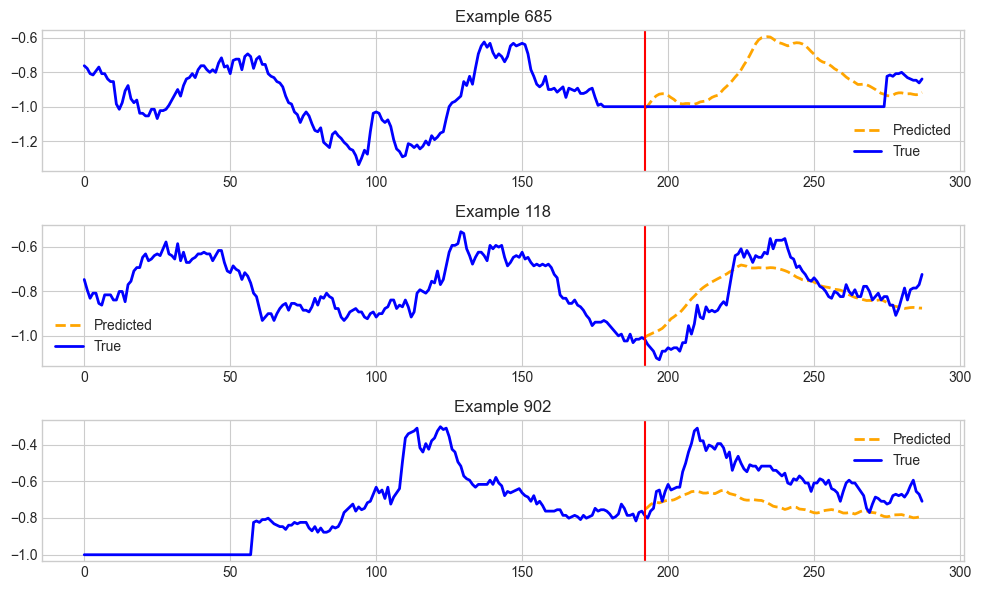

In [9]:
predictions_dict = zeroshot_eval(
    dataset_name=TARGET_DATASET, context_length=CONTEXT_LENGTH, forecast_length=PREDICTION_LENGTH, batch_size=64
)

 ## Few-shot finetune and evaluation method

In [12]:
def fewshot_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    tsp = TimeSeriesPreprocessor(
        **column_specifiers,
        context_length=context_length,
        prediction_length=forecast_length,
        scaling=True,
        encode_categorical=False,
        scaler_type="standard",
    )
    print("+" * 20, "TSP values", "+" * 20)
    print(tsp.prediction_channel_indices)
    print(tsp.exogenous_channel_indices)
    print(tsp.context_length)
    print(tsp.prediction_length)
    print(tsp.num_input_channels)
    print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            head_dropout=0.2,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=fewshot_percent / 100,
        fewshot_location="first",
        use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    )
    print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v1_fft"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train) / (batch_size)),
    )

    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

### Fine-tuning on full dataset (using 100% train split)

INFO:p-47662:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2


-------------------- Running few-shot 100% --------------------
++++++++++++++++++++ TSP values ++++++++++++++++++++
[0]
[]
512
96
1
standard


INFO:p-47662:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-47662:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


after get_datasets ------ 33953
Number of params before freezing backbone 805280
Number of params after freezing the backbone 289696
Using learning rate = 0.001


[TrackingCallback] Mean Epoch Time = 70.89085528850555 seconds, Total Train Time = 1318.555334329605
++++++++++++++++++++ Test MSE after few-shot 100% fine-tuning ++++++++++++++++++++


{'eval_loss': 0.026284104213118553, 'eval_runtime': 60.9469, 'eval_samples_per_second': 187.458, 'eval_steps_per_second': 2.937, 'epoch': 10.0}
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
prediction metrics on test set {'test_loss': 0.026284104213118553, 'test_runtime': 63.4431, 'test_samples_per_second': 180.083, 'test_steps_per_second': 2.821}
(11425, 96, 1)
(11425, 1, 8, 192)


PredictionOutput(predictions=(array([[[-0.8660686 ],
        [-0.8711204 ],
        [-0.8755778 ],
        ...,
        [-0.8714089 ],
        [-0.87347174],
        [-0.8721739 ]],

       [[-0.87017494],
        [-0.87548304],
        [-0.88086545],
        ...,
        [-0.8751965 ],
        [-0.87638813],
        [-0.87440574]],

       [[-0.8856228 ],
        [-0.89017236],
        [-0.8952067 ],
        ...,
        [-0.88517326],
        [-0.8863767 ],
        [-0.8839106 ]],

       ...,

       [[-1.4750723 ],
        [-1.4736984 ],
        [-1.4748272 ],
        ...,
        [-1.4317715 ],
        [-1.4320934 ],
        [-1.428445  ]],

       [[-1.482099  ],
        [-1.4815645 ],
        [-1.482925  ],
        ...,
        [-1.4384604 ],
        [-1.4385355 ],
        [-1.43506   ]],

       [[-1.4500747 ],
        [-1.4501984 ],
        [-1.4534179 ],
        ...,
        [-1.4196588 ],
        [-1.4193127 ],
        [-1.416888  ]]], dtype=float32), array([[[[-0.005391  , 

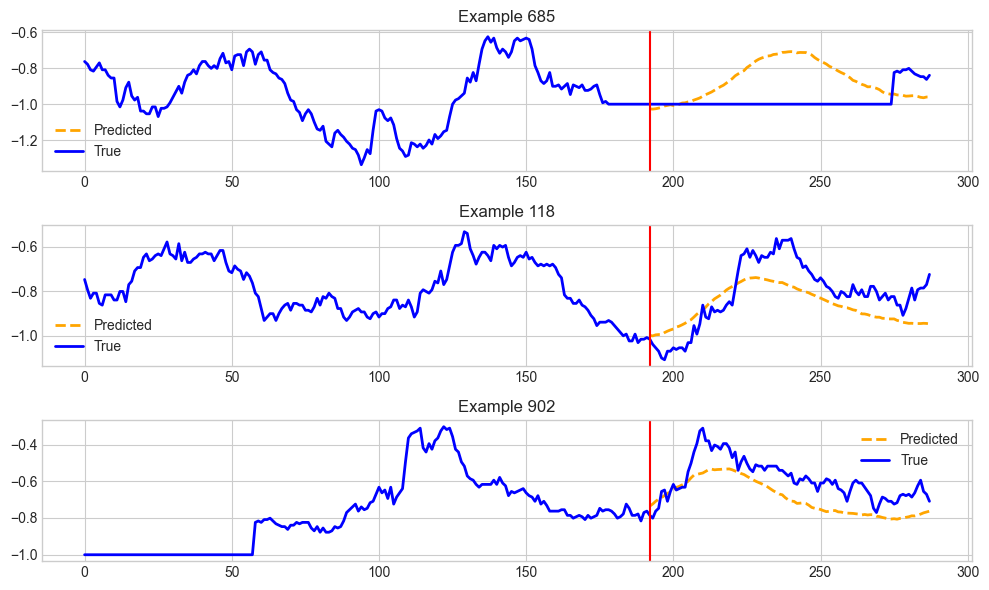

In [13]:
fewshot_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

# Analysis of TTM model on ETTm1 data

In [14]:
tsp = TimeSeriesPreprocessor(
    **column_specifiers,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    scaling=True,
    encode_categorical=False,
    scaler_type="standard",
)

dset_train, dset_val, dset_test = get_datasets(
        tsp,
        data,
        split_config,
        fewshot_fraction=1,
        fewshot_location="first",
        use_frequency_token=None,
    )
print("Length of train/val/test", len(dset_train), len(dset_val), len(dset_test))

print("Prediction channel indices derived from the preprocessor(TSP) methods - ", tsp.prediction_channel_indices)
print("Exogenous channel indices derived from the preprocessor(TSP) methods - ", tsp.exogenous_channel_indices)


Length of train/val/test 33953 11425 11425
Prediction channel indices derived from the preprocessor(TSP) methods -  [0]
Exogenous channel indices derived from the preprocessor(TSP) methods -  []


# Performance check on Validation set (Zero-shot and Finetuned model)

### Zero-shot 

In [15]:
# Load model
zeroshot_val_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    freq=None,
    prefer_l1_loss=False,
    prefer_longer_context=True,
    # adding TTM model config
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_val_trainer = Trainer(
    model=zeroshot_val_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=BATCH_SIZE,
        seed=SEED,
        report_to="none",
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Val MSE zero-shot", "+" * 20)
zeroshot_val_output = zeroshot_val_trainer.evaluate(dset_val)
print("zeroshot performance on validation set", zeroshot_val_output)


INFO:p-47662:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-47662:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-47662:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Val MSE zero-shot ++++++++++++++++++++


zeroshot performance on validation set {'eval_loss': 0.054009366780519485, 'eval_model_preparation_time': 0.0013, 'eval_runtime': 2.467, 'eval_samples_per_second': 4631.122, 'eval_steps_per_second': 72.558}


### Fine-tuned 

In [16]:
# loading the fine-tuned TTM model

fft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/ettm1/v1_fft/checkpoint-2655")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Val MSE fine-tuned", "+" * 20)
fft_val_output = fft_trainer.evaluate(dset_val)
print("fullshot finetuned performance on validation set", fft_val_output)


++++++++++++++++++++ Val MSE fine-tuned ++++++++++++++++++++


fullshot finetuned performance on validation set {'eval_loss': 0.049136966466903687, 'eval_model_preparation_time': 0.0012, 'eval_runtime': 2.5865, 'eval_samples_per_second': 4417.142, 'eval_steps_per_second': 69.205}


In [17]:
zs_val_preds = zeroshot_val_trainer.predict(dset_val)
fft_val_preds = fft_trainer.predict(dset_val)

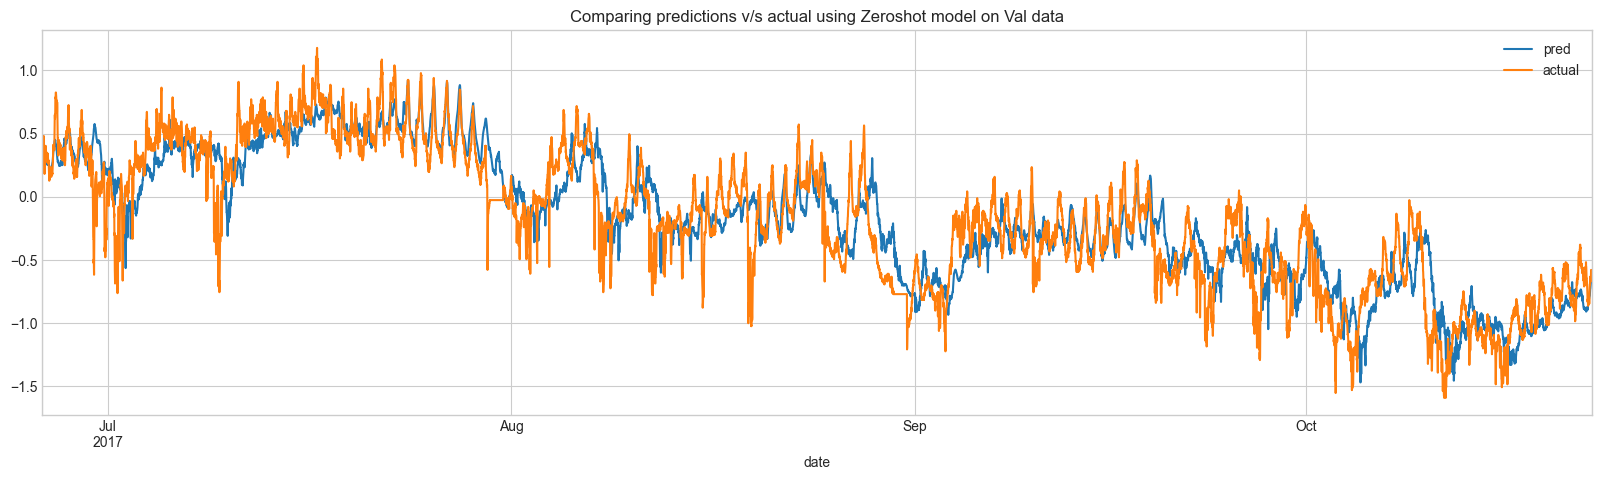

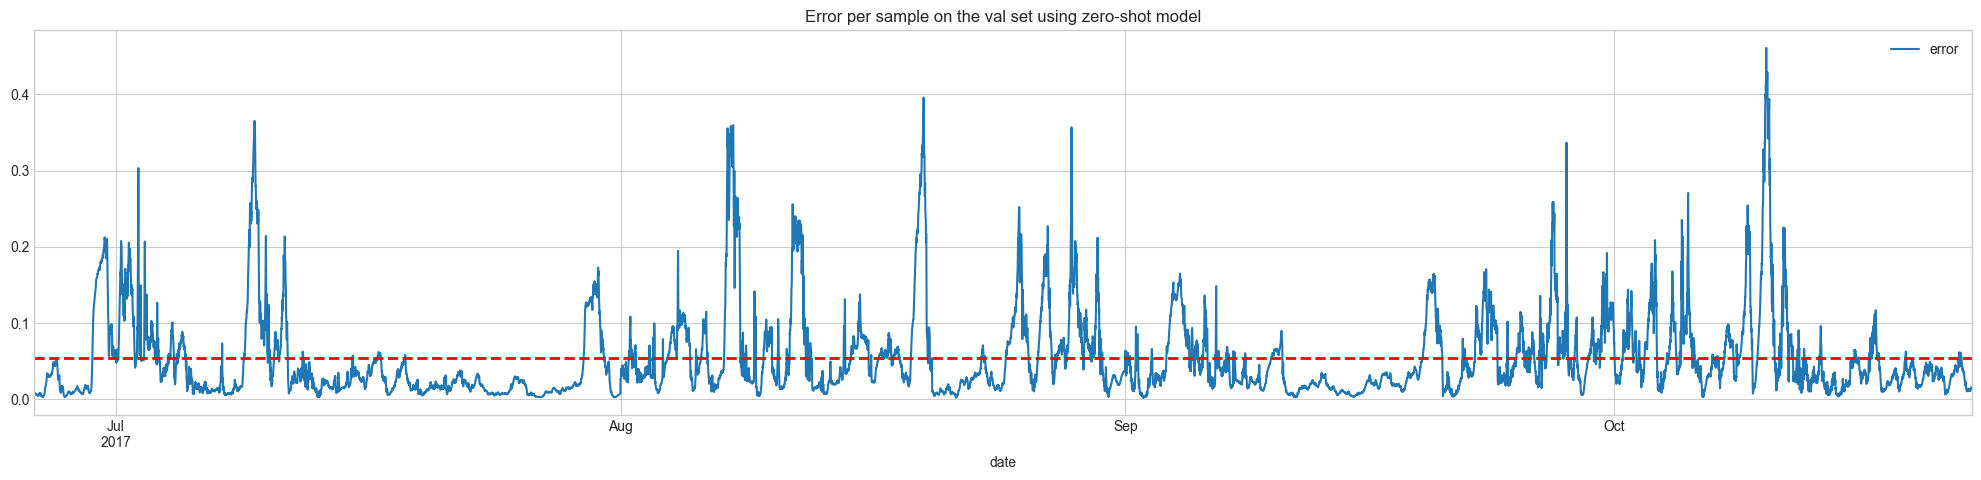

In [21]:
zs_val_df = construct_output_df(dset_val, zeroshot_val_trainer)
zs_out_predictions = compare_forecast(zs_val_df, "date", "prediction", "actual", 60)
zs_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Zeroshot model on Val data")

zs_val_df["error"] = zs_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax1 = zs_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the val set using zero-shot model")
ax1.axhline(y=zs_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_val_df['error'].mean():.3f}")


In [22]:
high_error_val_samples = zs_val_df[zs_val_df["error"]>0.2]
high_error_val_samples

date                                         prediction  \
413   2017-06-30 07:00:00  [0.34769818, 0.34966412, 0.35494724, 0.3607565...   
414   2017-06-30 07:15:00  [0.38513842, 0.38456917, 0.38566086, 0.3920094...   
415   2017-06-30 07:30:00  [0.40396175, 0.4009557, 0.4046615, 0.41352797,...   
416   2017-06-30 07:45:00  [0.3815724, 0.38571575, 0.39434713, 0.40323675...   
417   2017-06-30 08:00:00  [0.37061697, 0.38046888, 0.38833854, 0.3988575...   
...                   ...                                                ...   
10315 2017-10-11 10:30:00  [-0.9098948, -0.91136456, -0.89971626, -0.8934...   
10319 2017-10-11 11:30:00  [-0.89604867, -0.89806914, -0.88759613, -0.879...   
10320 2017-10-11 11:45:00  [-0.8769909, -0.8752047, -0.8652611, -0.856359...   
10321 2017-10-11 12:00:00  [-0.8904904, -0.88765526, -0.8764008, -0.86574...   
10322 2017-10-11 12:15:00  [-0.8968566, -0.8928746, -0.88029253, -0.87211...   

                                                  actual  \
413    [0.3877723, 0.40314353, 0.3724013, 0.35713902,...   
414    [0.40314353, 0.3724013, 0.35713902, 0.341768, ...   
415    [0.3724013, 0.35713902, 0.341768, 0.3263968, 0...   
416    [0.35713902, 0.341768, 0.3263968, 0.341768, 0....   
417    [0.341768, 0.3263968, 0.341768, 0.26502126, 0....   
...                                                  ...   
10315  [-0.9849466, -0.94657326, -0.93894225, -0.9083...   
10319  [-0.89293784, -0.9159401, -0.9235711, -0.96957...   
10320  [-0.9159401, -0.9235711, -0.9695755, -0.992577...   
10321  [-0.9235711, -0.9695755, -0.9925777, -1.007948...   
10322  [-0.9695755, -0.9925777, -1.0079489, -1.030951...   

                                                 context  \
413    [0.42614576, 0.4951523, 0.50278336, 0.44914803...   
414    [0.4951523, 0.50278336, 0.44914803, 0.46441007...   
415    [0.50278336, 0.44914803, 0.46441007, 0.4721500...   
416    [0.44914803, 0.46441007, 0.47215006, 0.4337768...   
417    [0.46441007, 0.47215006, 0.4337768, 0.4797811,...   
...                                                  ...   
10315  [-0.7701867, -0.75492465, -0.7701867, -0.82393...   
10319  [-0.86230457, -0.8239312, -0.7779268, -0.77792...   
10320  [-0.8239312, -0.7779268, -0.7779268, -0.754924...   
10321  [-0.7779268, -0.7779268, -0.75492465, -0.80092...   
10322  [-0.7779268, -0.75492465, -0.80092907, -0.7625...   

                                             full_window     error  
413    [0.42614576, 0.4951523, 0.50278336, 0.44914803...  0.201774  
414    [0.4951523, 0.50278336, 0.44914803, 0.46441007...  0.209105  
415    [0.50278336, 0.44914803, 0.46441007, 0.4721500...  0.212456  
416    [0.44914803, 0.46441007, 0.47215006, 0.4337768...  0.209844  
417    [0.46441007, 0.47215006, 0.4337768, 0.4797811,...  0.210558  
...                                                  ...       ...  
10315  [-0.7701867, -0.75492465, -0.7701867, -0.82393...  0.211367  
10319  [-0.86230457, -0.8239312, -0.7779268, -0.77792...  0.209960  
10320  [-0.8239312, -0.7779268, -0.7779268, -0.754924...  0.224214  
10321  [-0.7779268, -0.7779268, -0.75492465, -0.80092...  0.215290  
10322  [-0.7779268, -0.75492465, -0.80092907, -0.7625...  0.207621  

[408 rows x 6 columns]

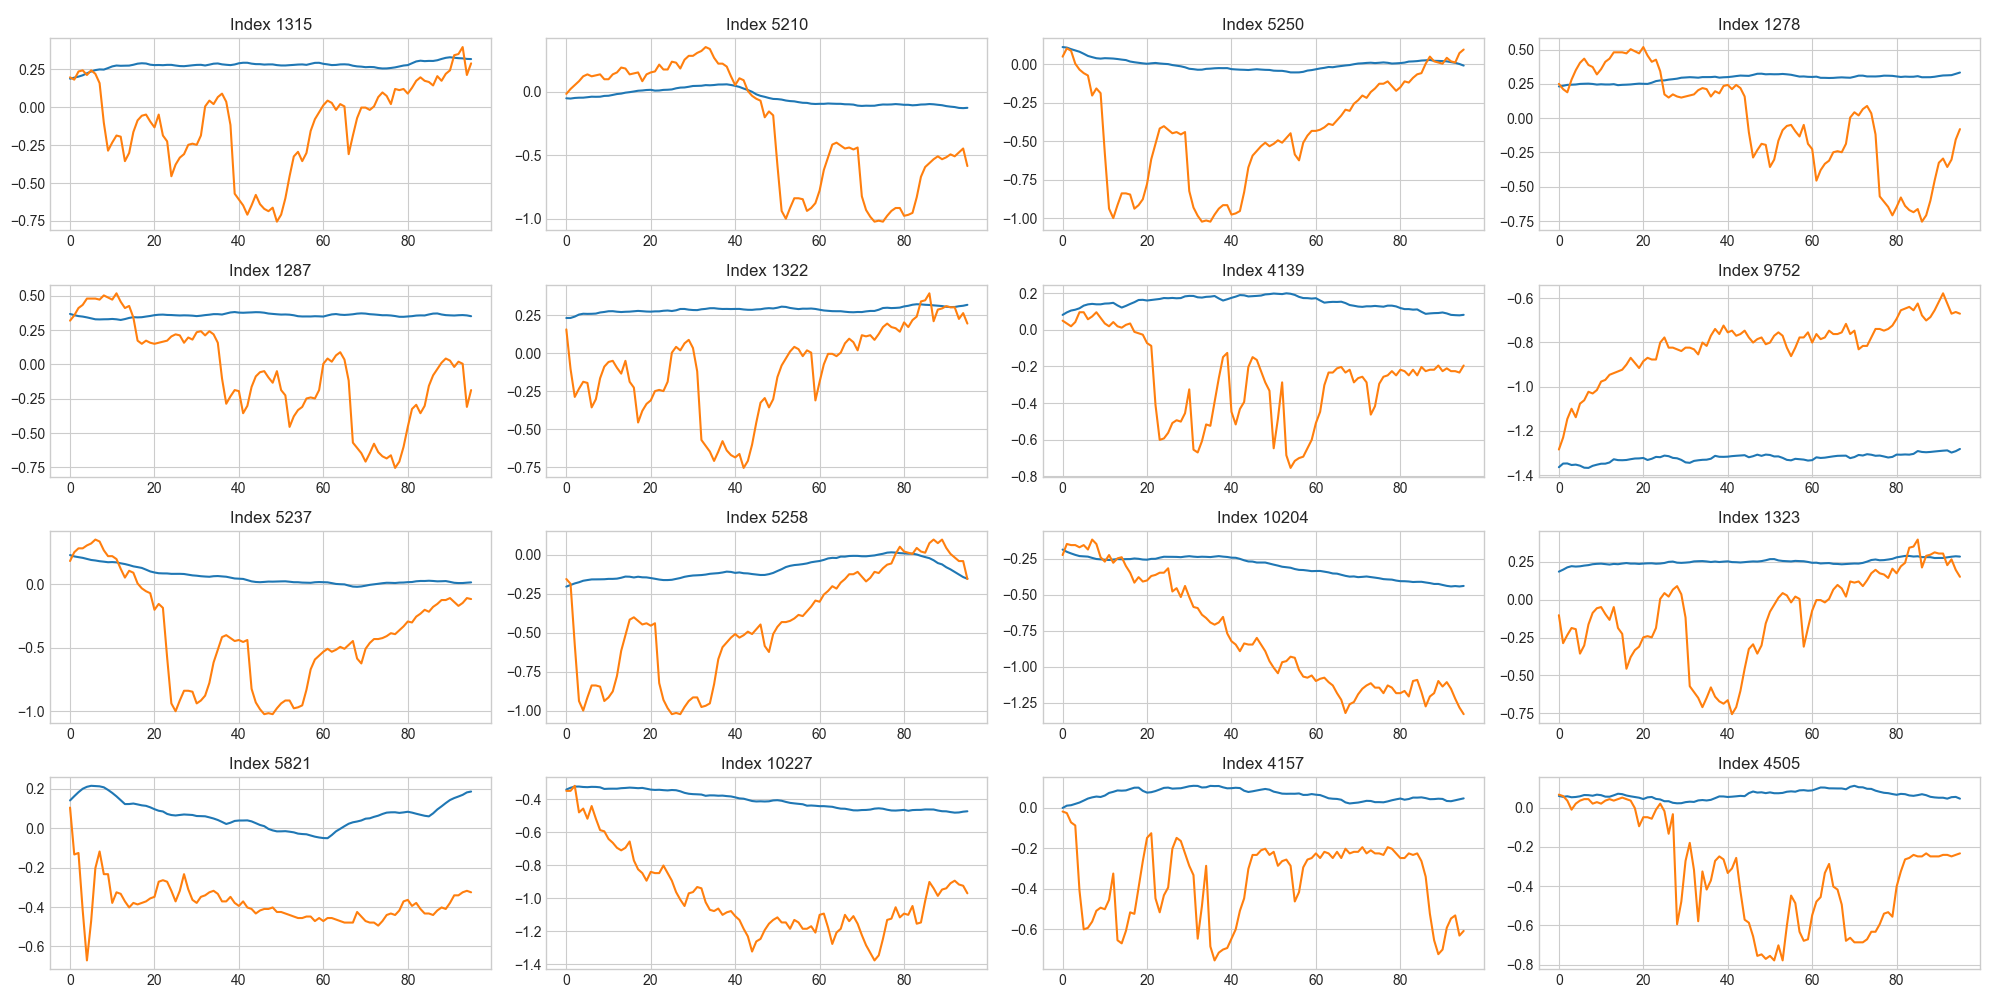

In [23]:
plot_high_error_samples(4, 4, zs_val_df, 0.2)


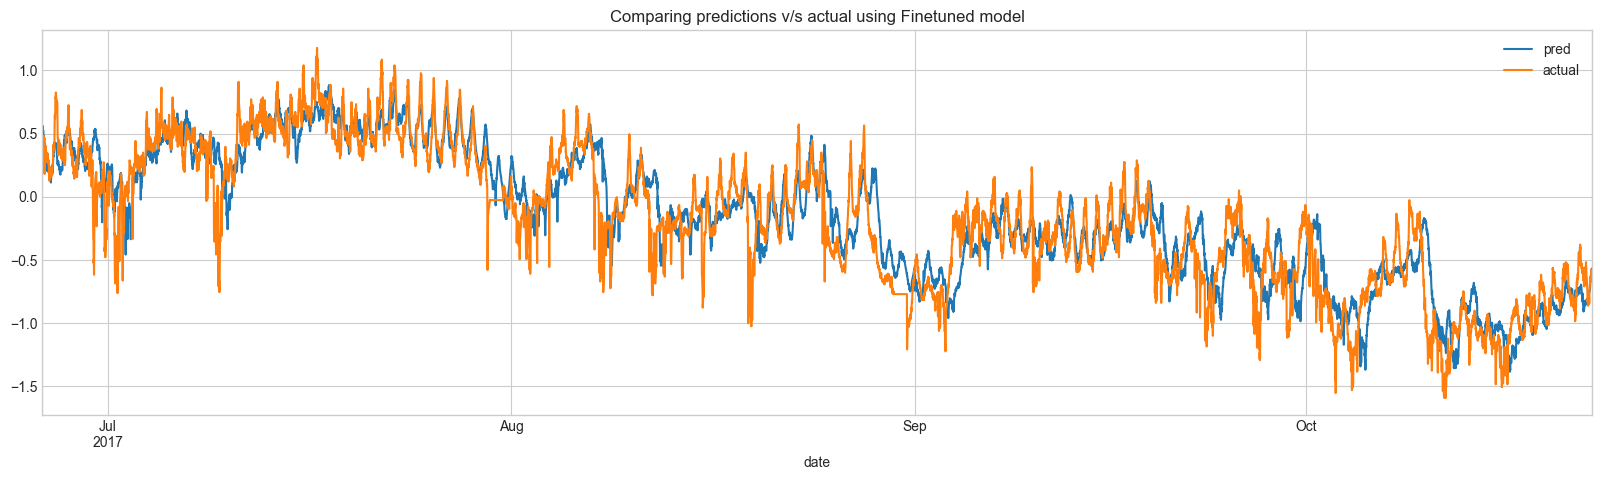

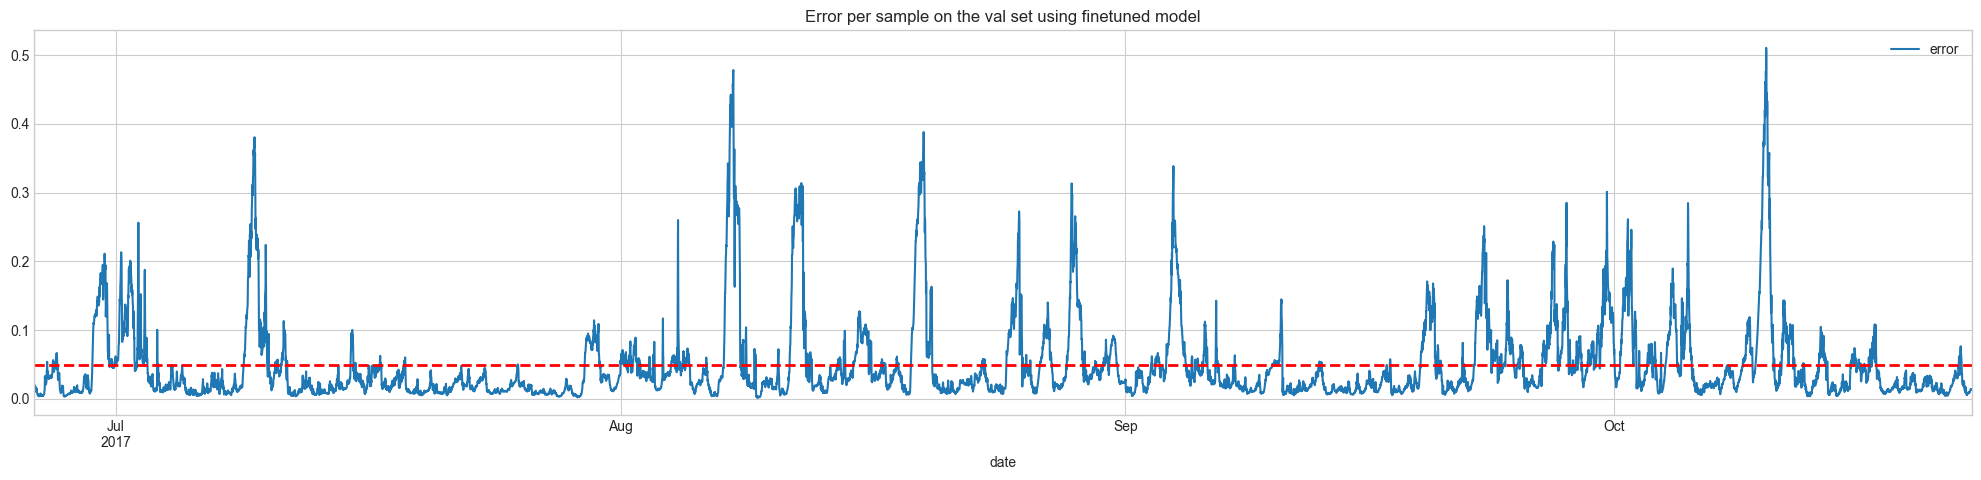

In [25]:
fft_val_df = construct_output_df(dset_val, fft_trainer)
ft_out_predictions = compare_forecast(fft_val_df, "date", "prediction", "actual", 60)
ft_out_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Finetuned model")

fft_val_df["error"] = fft_val_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax2 = fft_val_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the val set using finetuned model")
ax2.axhline(y=fft_val_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {fft_val_df['error'].mean():.3f}")

In [ ]:
plot_high_error_samples(4, 5, fft_val_df, 0.3)

# Performance check on Test set (Zero-shot and Finetuned model)

### Zeroshot

In [26]:
# Load model
zeroshot_test_model = get_model(
    TTM_MODEL_PATH,
    context_length=CONTEXT_LENGTH,
    prediction_length=PREDICTION_LENGTH,
    freq_prefix_tuning=False,
    freq=None,
    prefer_l1_loss=False,
    prefer_longer_context=True,
    # adding TTM model config
    prediction_channel_indices=tsp.prediction_channel_indices,
    num_input_channels=tsp.num_input_channels,
)
temp_dir = tempfile.mkdtemp()

# zeroshot_trainer
zeroshot_test_trainer = Trainer(
    model=zeroshot_test_model,
    args=TrainingArguments(
        output_dir=temp_dir,
        per_device_eval_batch_size=BATCH_SIZE,
        seed=SEED,
        report_to="none",
    ),
)
# evaluate = zero-shot performance
print("+" * 20, "Test MSE zero-shot", "+" * 20)
zeroshot_test_output = zeroshot_test_trainer.evaluate(dset_test)
print("zeroshot performance on test set", zeroshot_test_output)

INFO:p-47662:t-8466403200:get_model.py:get_model:Loading model from: ibm-granite/granite-timeseries-ttm-r2
INFO:p-47662:t-8466403200:get_model.py:get_model:Model loaded successfully from ibm-granite/granite-timeseries-ttm-r2, revision = main.
INFO:p-47662:t-8466403200:get_model.py:get_model:[TTM] context_length = 512, prediction_length = 96


++++++++++++++++++++ Test MSE zero-shot ++++++++++++++++++++


zeroshot performance on test set {'eval_loss': 0.02748260647058487, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 2.6643, 'eval_samples_per_second': 4288.126, 'eval_steps_per_second': 67.184}


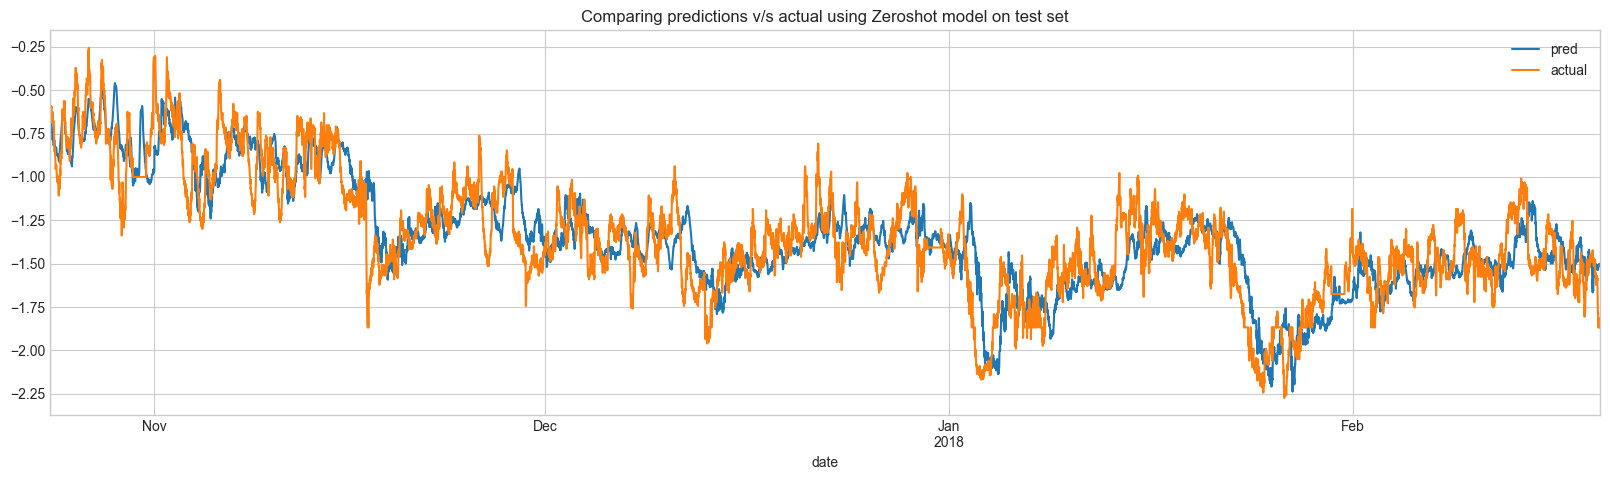

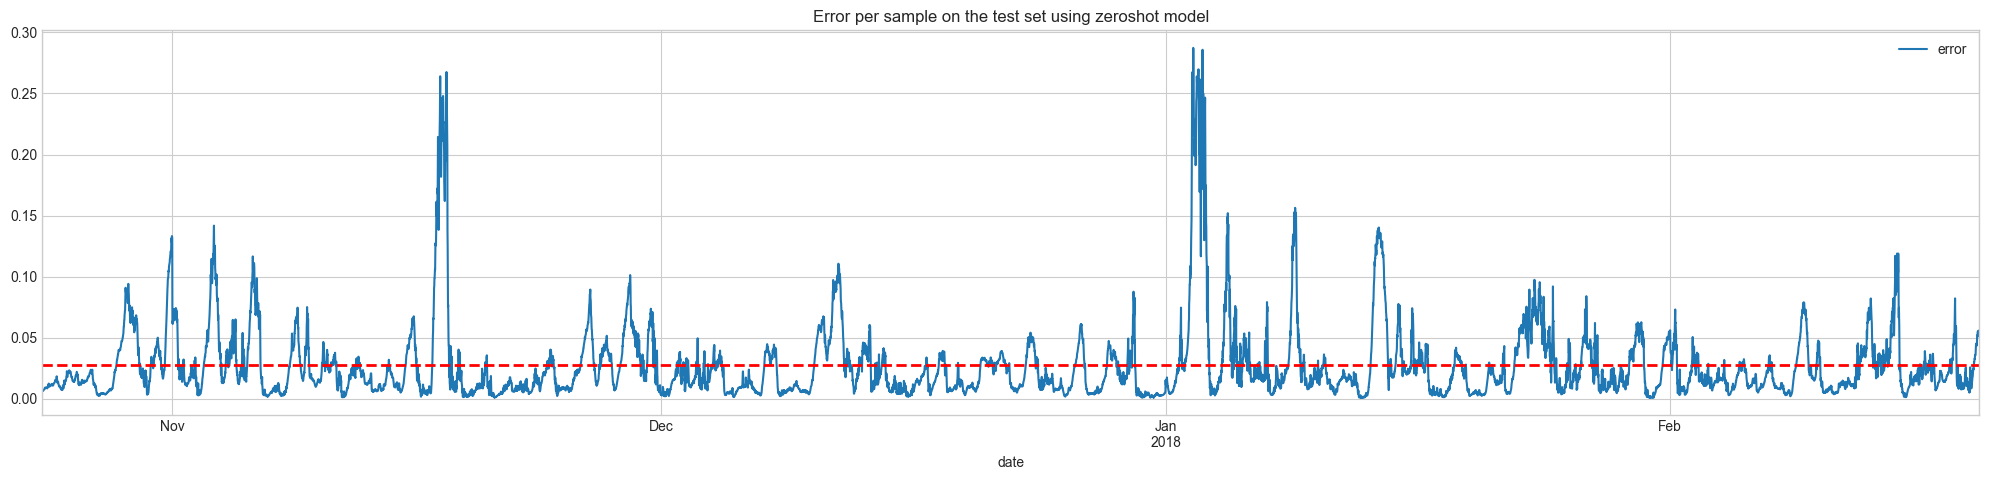

In [33]:
zs_test_df = construct_output_df(dset_test, zeroshot_val_trainer)
zs_test_predictions = compare_forecast(zs_test_df, "date", "prediction", "actual", 60)
zs_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Zeroshot model on test set")

zs_test_df["error"] = zs_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax3 = zs_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using zeroshot model")
ax3.axhline(y=zs_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {zs_test_df['error'].mean():.3f}")

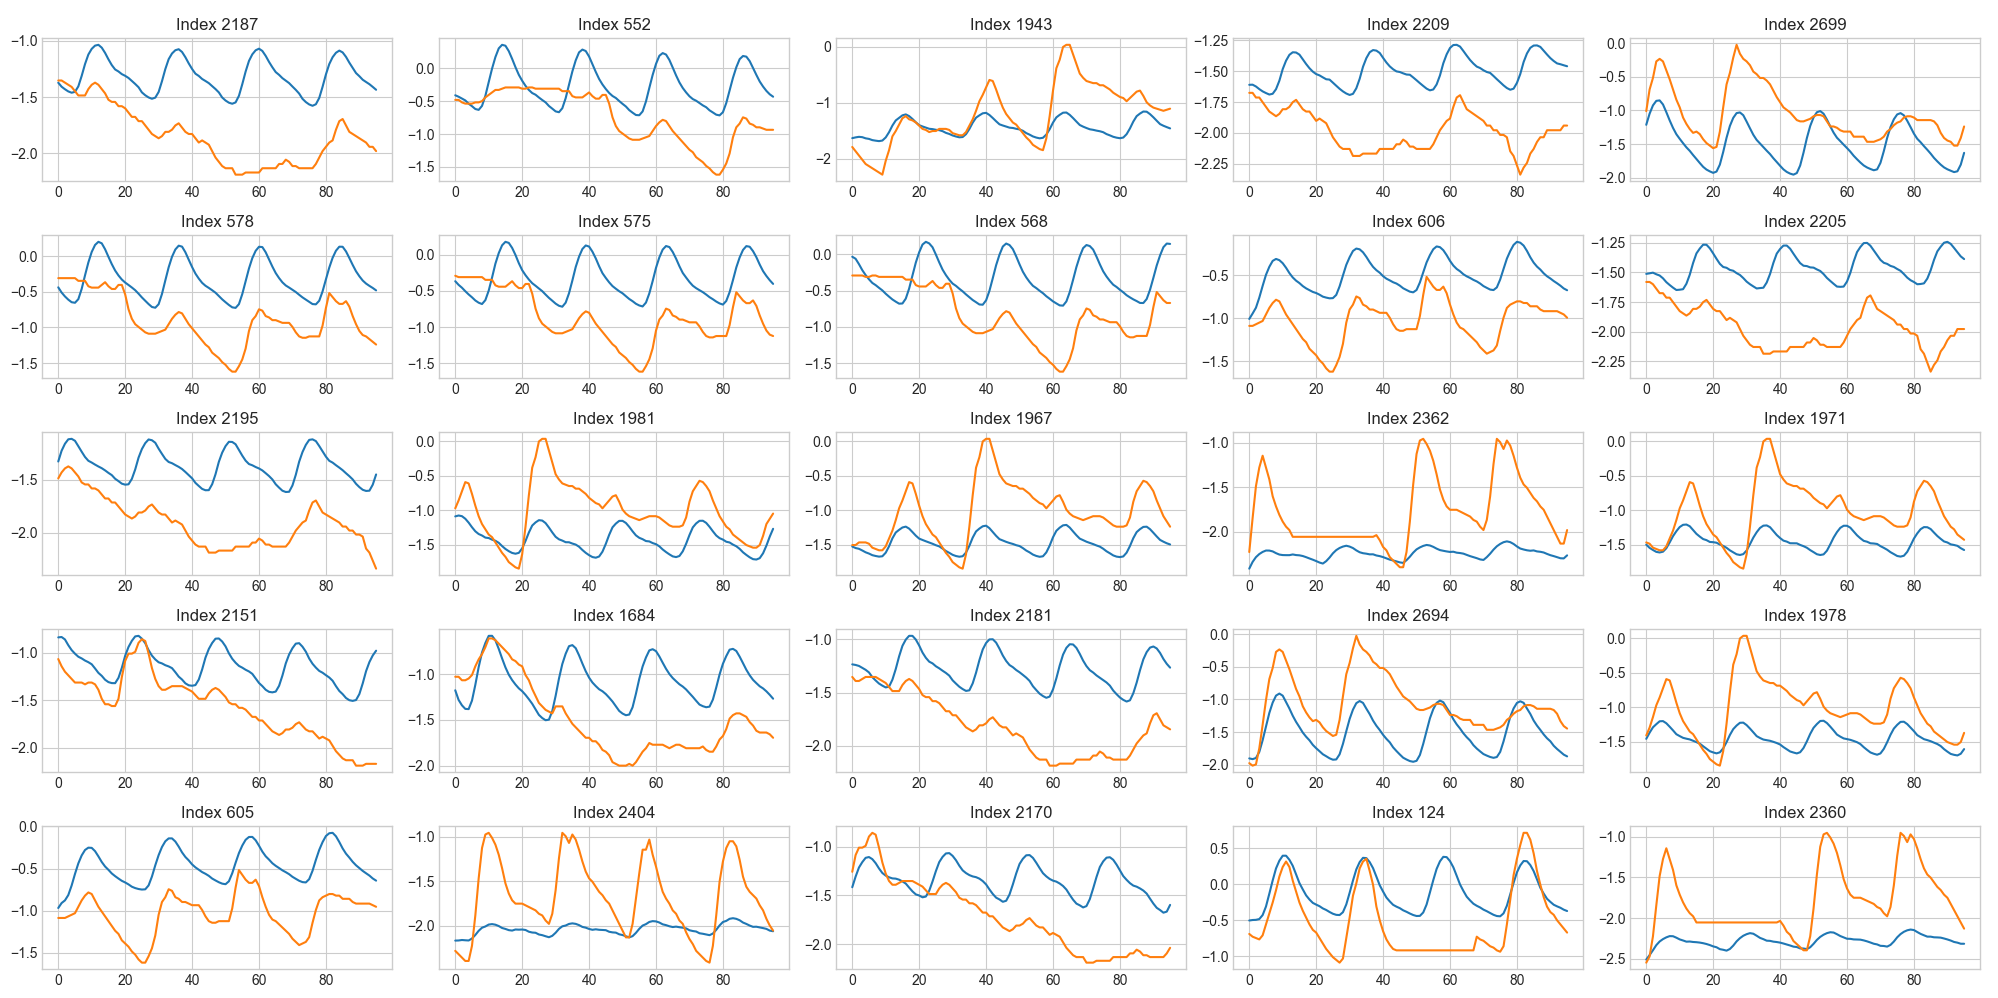

In [24]:
plot_high_error_samples(5, 5, zs_test_df, 0.25)

### Fine-Tuned

In [28]:
fine_tuned_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/ettm1/v1_fft/checkpoint-2655")
temp_dir = tempfile.mkdtemp()

fft_trainer = Trainer(
        model=fine_tuned_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Val MSE fine-tuned", "+" * 20)
fft_test_output = fft_trainer.evaluate(dset_test)
print("finetuned performance on test set", fft_test_output)

++++++++++++++++++++ Val MSE fine-tuned ++++++++++++++++++++


finetuned performance on test set {'eval_loss': 0.026284104213118553, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 2.4906, 'eval_samples_per_second': 4587.279, 'eval_steps_per_second': 71.871}


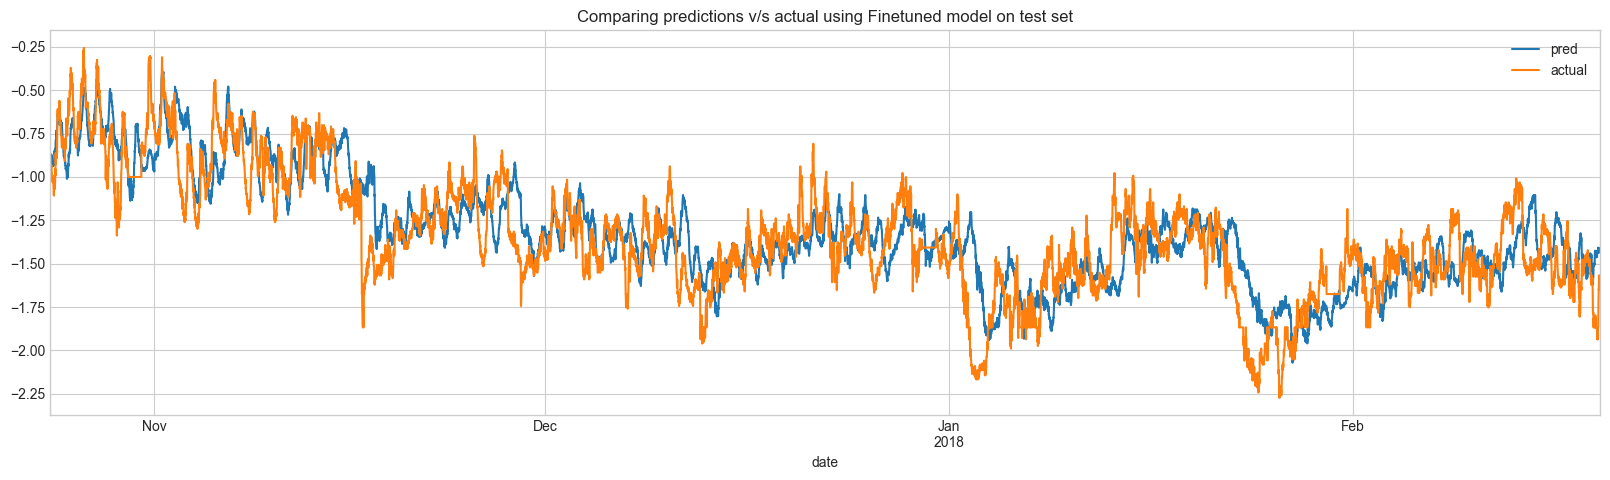

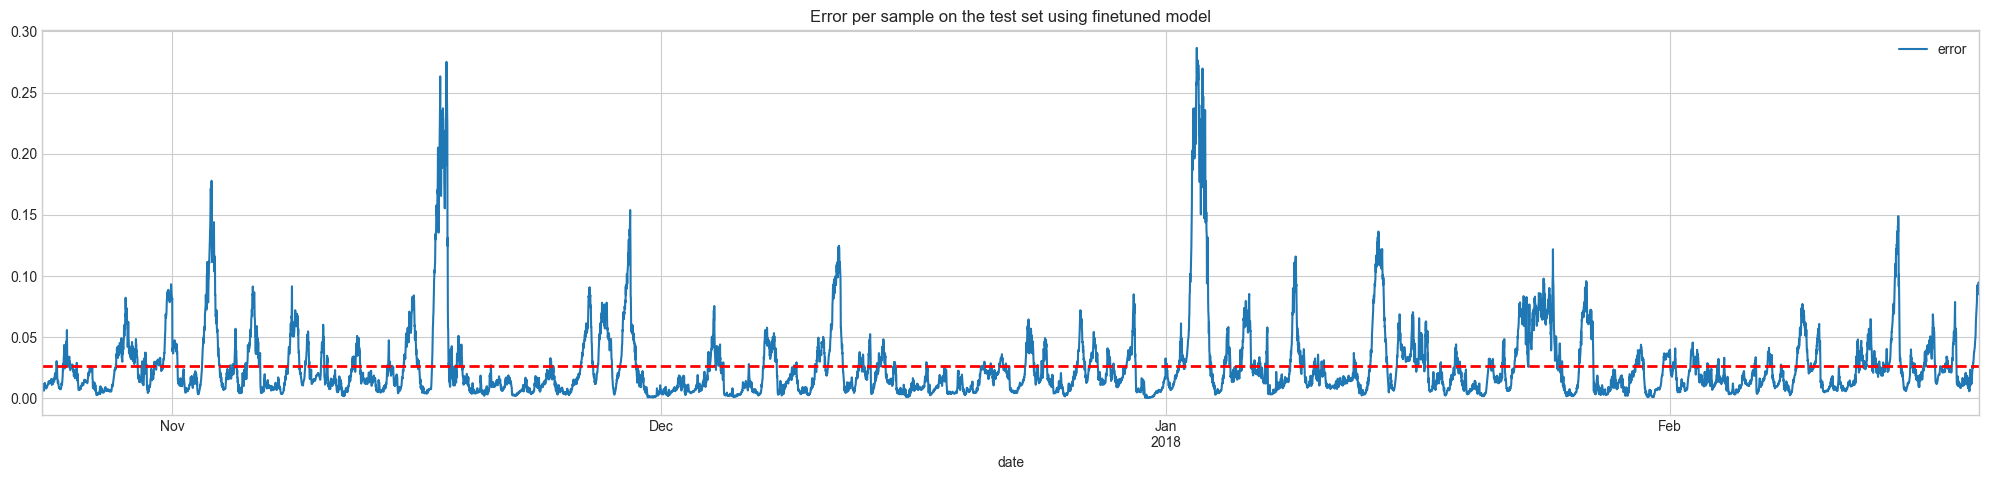

In [30]:
fft_test_df = construct_output_df(dset_test, fft_trainer)
ft_test_predictions = compare_forecast(fft_test_df, "date", "prediction", "actual", 96)
ft_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using Finetuned model on test set")

fft_test_df["error"] = fft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax3 = fft_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using finetuned model")
ax3.axhline(y=fft_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {fft_test_df['error'].mean():.3f}")

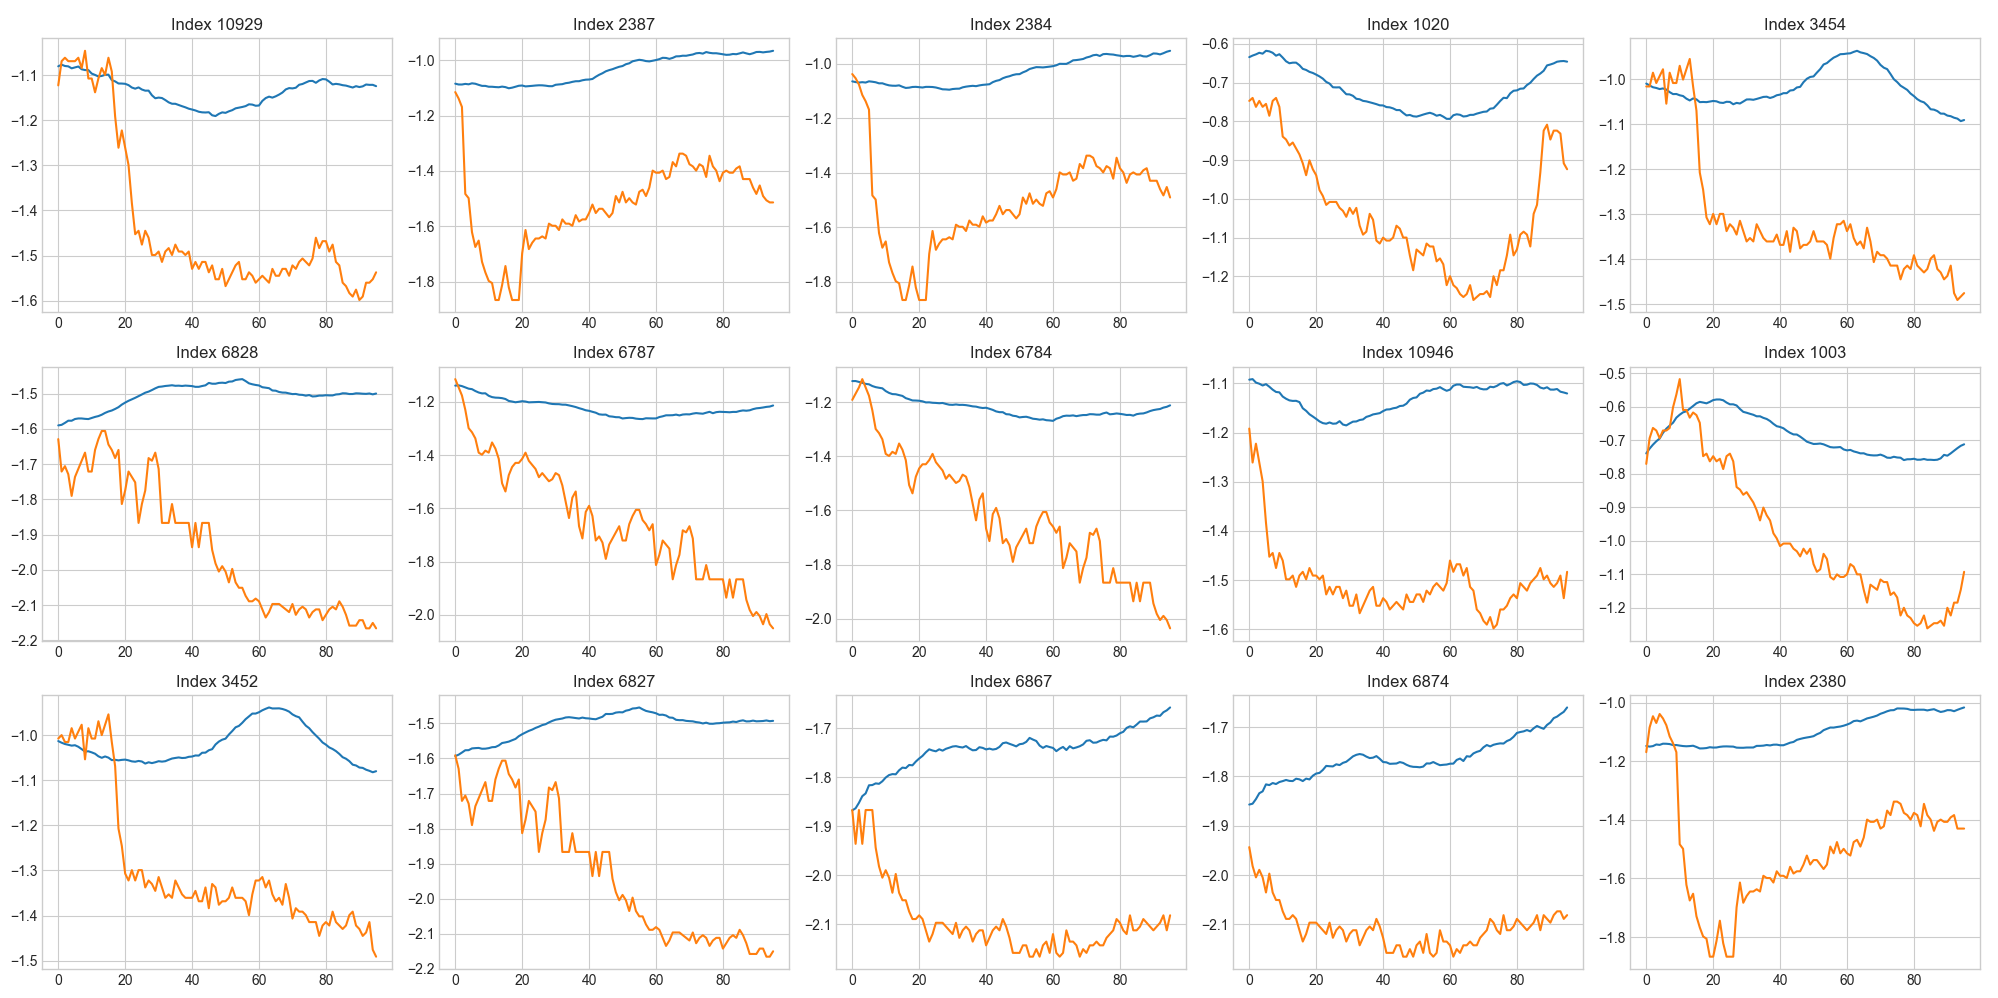

In [31]:
plot_high_error_samples(3, 5, fft_test_df, 0.1)

In [35]:
columns = ["ETTm1", "Validation", "Test"]
rows = [
    ["ZS", 0.0540 , 0.0274],
    ["FT", 0.0491 , 0.0262], 
]
res_df = pd.DataFrame(rows, columns=columns)
print(res_df)



  ETTm1  Validation    Test
0    ZS      0.0540  0.0274
1    FT      0.0491  0.0262


In [ ]:
# targeted training of model 

def targeted_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    # tsp = TimeSeriesPreprocessor(
    #     **column_specifiers,
    #     context_length=context_length,
    #     prediction_length=forecast_length,
    #     scaling=True,
    #     encode_categorical=False,
    #     scaler_type="standard",
    # )
    # print("+" * 20, "TSP values", "+" * 20)
    # print(tsp.prediction_channel_indices)
    # print(tsp.exogenous_channel_indices)
    # print(tsp.context_length)
    # print(tsp.prediction_length)
    # print(tsp.num_input_channels)
    # print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.7,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    # dset_train, dset_val, dset_test = get_datasets(
    #     tsp,
    #     data,
    #     split_config,
    #     fewshot_fraction=fewshot_percent / 100,
    #     fewshot_location="first",
    #     use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    # )
    # print("after get_datasets ------", len(dset_train))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v5_output"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train_filtered) / (batch_size)),
    )
    print("length of training set is", len(dset_train_filtered))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train_filtered,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=  .model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

In [ ]:
targeted_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [ ]:
targeted_ft_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v5_output/checkpoint-65")
temp_dir = tempfile.mkdtemp()

targeted_ft_trainer = Trainer(
        model=targeted_ft_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Test MSE fine-tuned", "+" * 20)
targeted_ft_output = targeted_ft_trainer.evaluate(dset_test)
print("targeted finetuned performance on test set", targeted_ft_output)

In [ ]:
targeted_ft_test_df = construct_output_df(dset_test, targeted_ft_trainer)
tar_test_predictions = compare_forecast(targeted_ft_test_df, "date", "prediction", "actual", 24)
tar_test_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using targeted finetuned model on test set")

targeted_ft_test_df["error"] = targeted_ft_test_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax4 = targeted_ft_test_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using finetuned model")
ax4.axhline(y=targeted_ft_test_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {targeted_ft_test_df['error'].mean():.3f}")




In [ ]:
plot_high_error_samples(3, 5, targeted_ft_test_df, 0.2)

<Axes: title={'center': 'Error per sample on the test set using finetuned and targeted models'}, xlabel='date'>

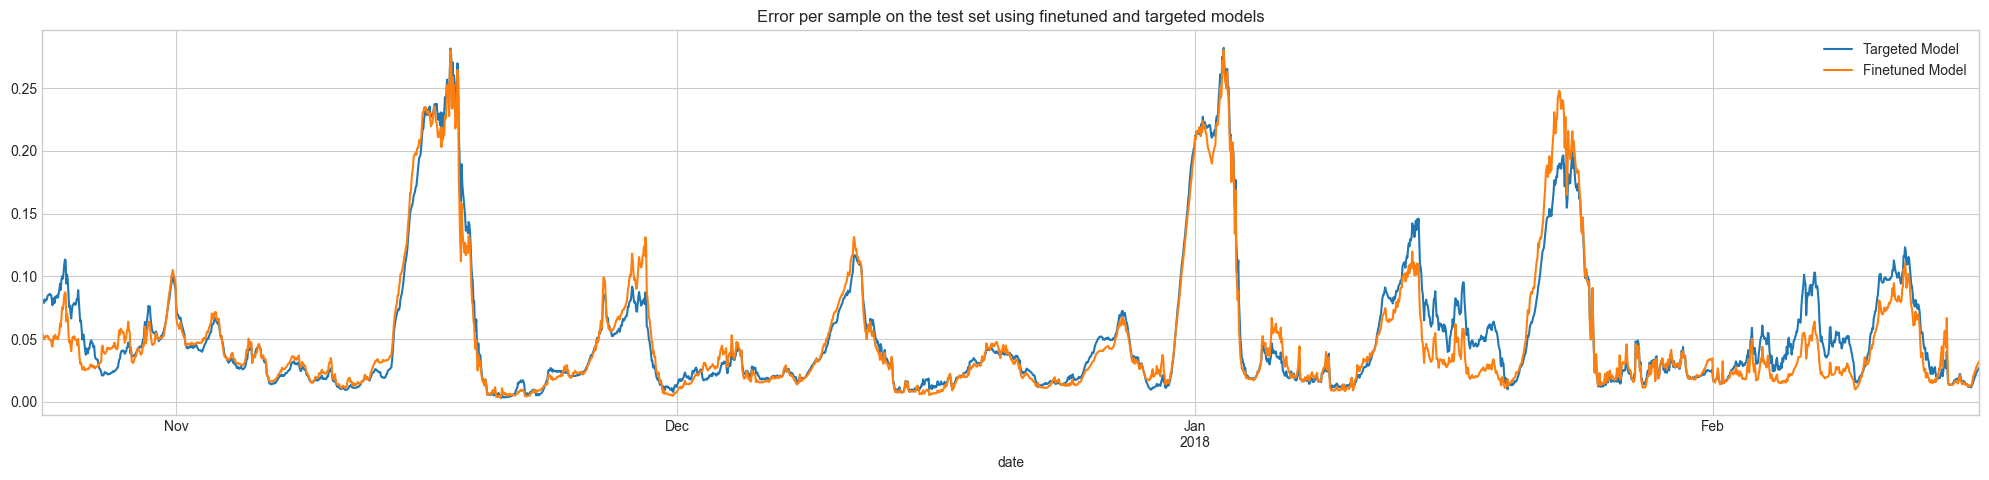

In [ ]:
ax5 = targeted_ft_test_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    label="Targeted Model",
    title="Error per sample on the test set using finetuned and targeted models"
)


fft_test_df.plot(
    x="date",
    y="error",
    ax=ax4,         
    label="Finetuned Model"
)

### Learning shapelets from high error val samples

In [36]:
import sys
sys.path.append("/Users/shivanitomar/Documents/Implementations/ps_pgsm_shapelets/incremental_code")
import utils

In [38]:
context_array = np.array(high_error_val_samples["context"].tolist())
context_array.shape


(408, 512)

In [39]:
n, p = context_array.shape
r = 0.2
q = int(np.ceil(p * r))
k = 50
S, A, Offsets, F_obj = utils.USIDL_with_alpha_const(context_array, lambda_=0.1, K=k, q=q, c=100, epsilon=1e-5,
                                                    maxIter=2e3, maxInnerIter=5, random_seed=32)
shapelet_dict_v7 = {f'shapelet_{i}': S[i] for i in range(S.shape[0])}

# base_path = f"/Users/shivanitomar/Documents/Implementations/autotune_extension/learned_shapelets/{dataset}[0].pkl"
# with open(base_path, 'wb') as f:
#     pickle.dump(shapelet_dict, f)

# return shapelet_dict

setting random seed to 32 for dictionary initialization
Converged!


In [41]:
len(shapelet_dict_v7)

50

In [42]:
#rank shapelets based on alpha coeff 
alpha_df = pd.DataFrame(A)
k=25

alpha_sum = alpha_df.sum(axis=0).to_frame().T
topk_shap_idx = alpha_sum.iloc[0].nlargest(k).index
df_top25 = alpha_sum[topk_shap_idx]

select_shapelets_v7 = {}
for key, value in shapelet_dict_v7.items():
    idx = int(key.split("_")[1])
    if idx in topk_shap_idx:
        select_shapelets_v7[key] = value
    

In [43]:
df_top25

15         29         6          21         20         3   \
0  41.131561  40.913467  40.819071  39.849789  39.715955  39.546744   

          2          19         41         27  ...         37         4   \
0  39.055914  38.905511  38.494859  38.250294  ...  35.329589  35.325236   

          36        46         30         49         5          9          44  \
0  35.268506  35.02379  34.780937  34.368584  34.336252  33.475992  33.235529   

          24  
0  33.074394  

[1 rows x 25 columns]

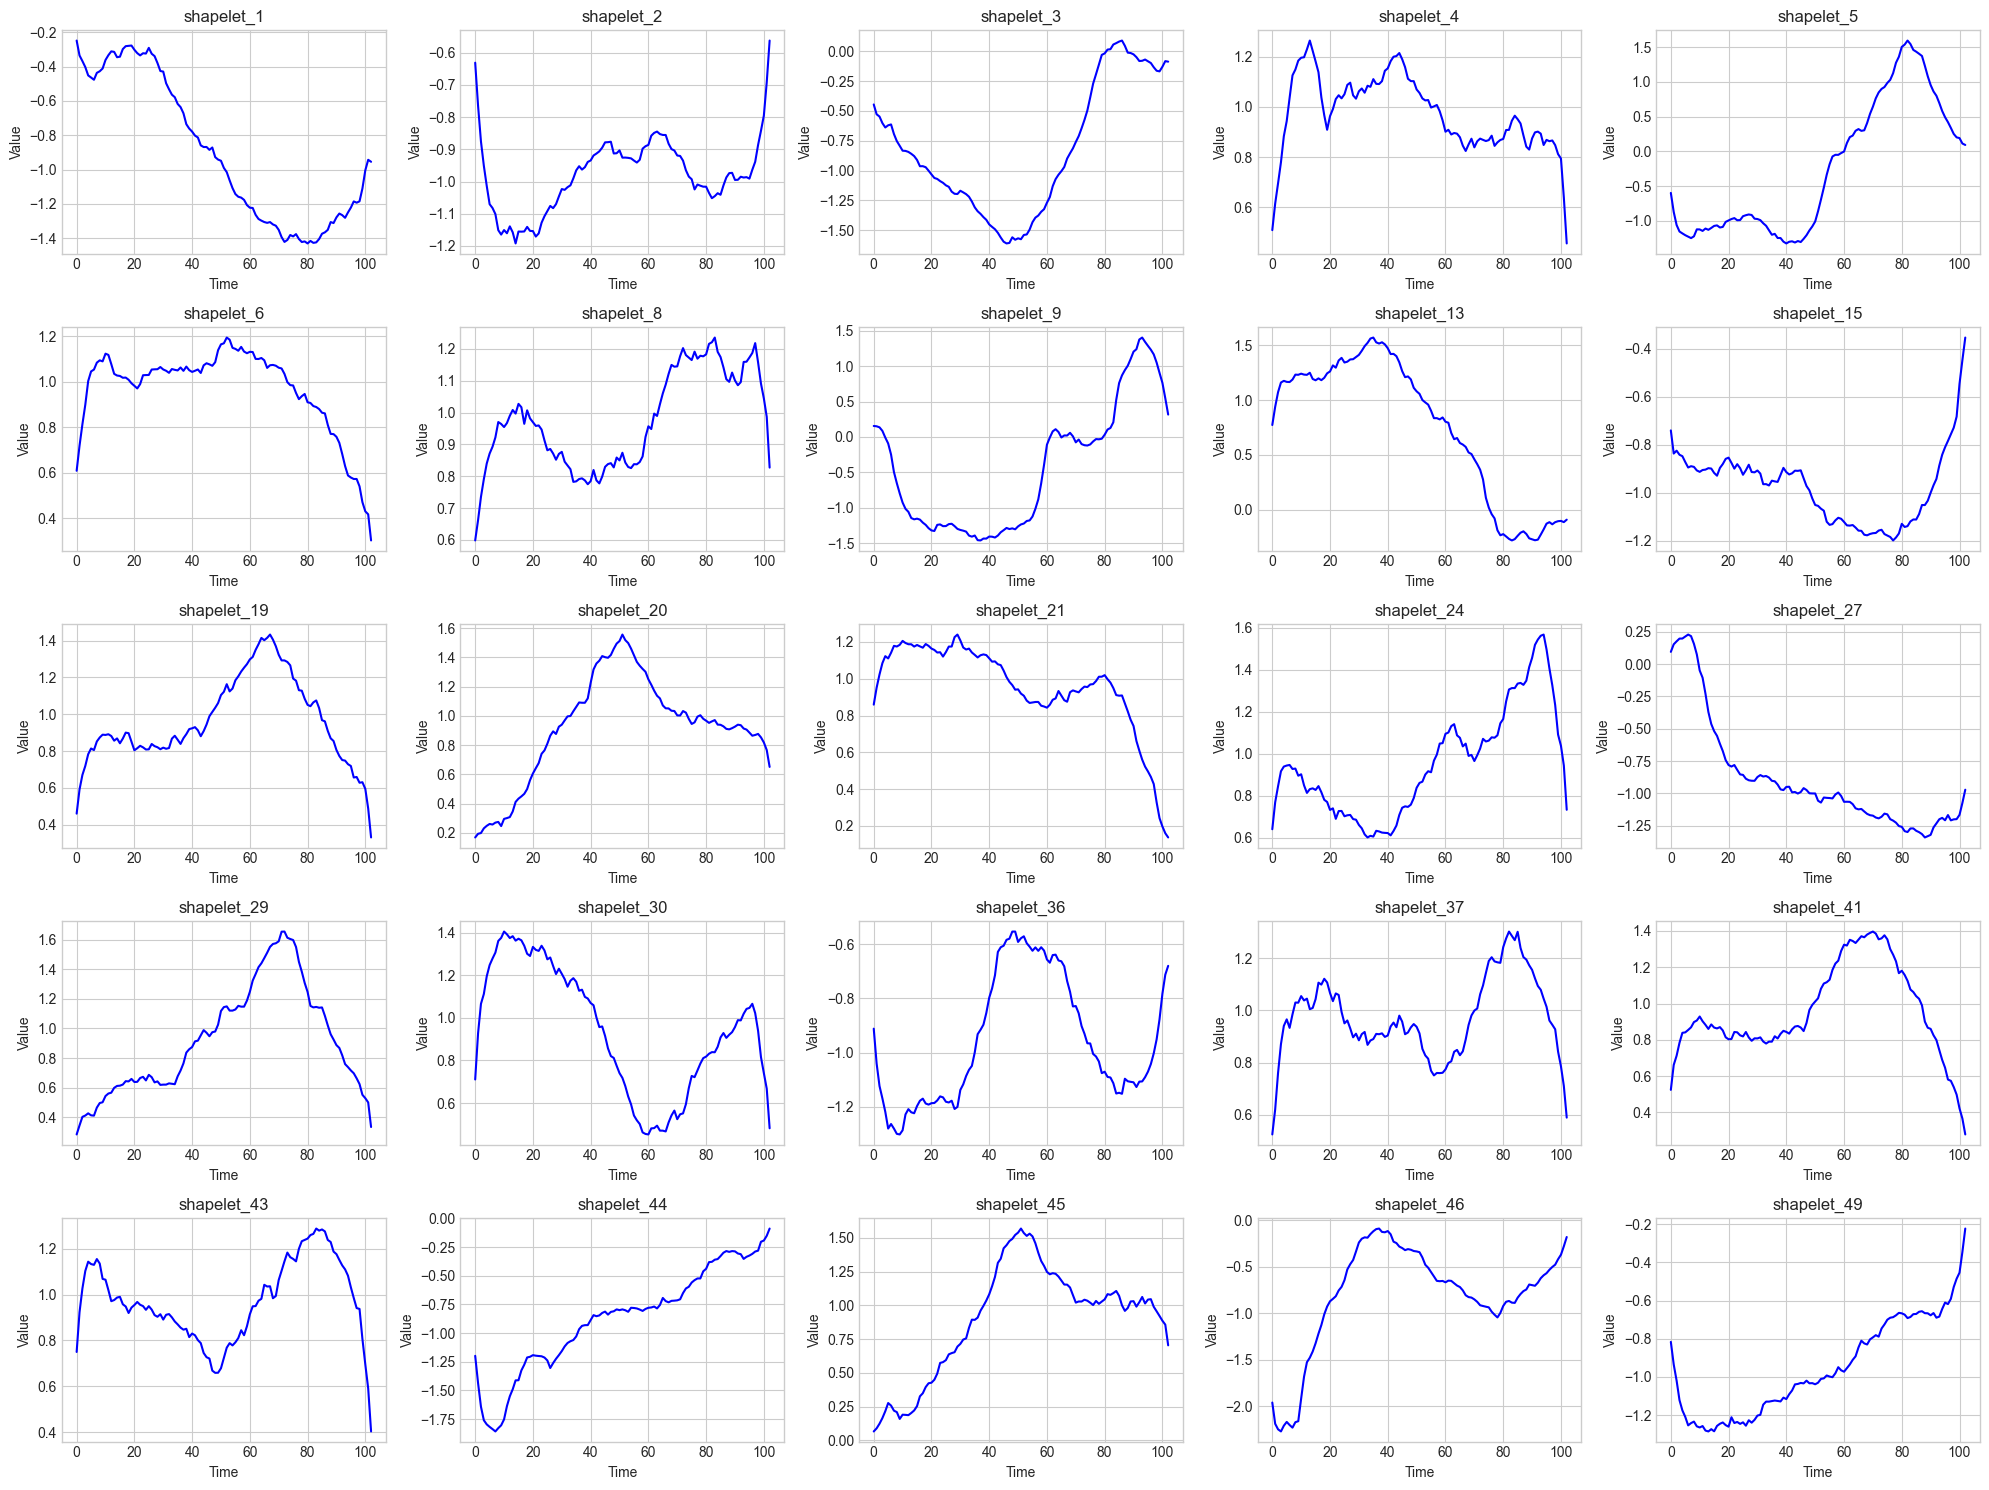

In [46]:
plot_shapelet_dict(select_shapelets_v7, 5)

In [47]:
import torch

# closest training samples to shapelets using ED learned from validation split 
def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))

train_set = []
timestamps = []

for i in range(len(dset_train)):
    sample = dset_train[i]['past_values']
    train_set.append(sample)
    timestamps.append(dset_train[i]['timestamp']) 

train_context = torch.stack(train_set).squeeze(-1).numpy()
train_context_reshaped = np.expand_dims(train_context, axis=1)
columns = [f"timepoint_{i}" for i in range(train_context.shape[1])]
train_context_df = pd.DataFrame(train_context, columns=columns)
train_context_df["timestamp"] = timestamps
train_context_df.set_index("timestamp", inplace=True)

target_train_ed = np.zeros((len(dset_train),len(select_shapelets_v7)))

# save all the test distances with shapelets in an array
for i in range(len(train_context_df)):
    for j, shapelet in enumerate(select_shapelets_v7.values()):
        series = np.array(dset_train[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        target_train_ed[i, j] = dist


In [48]:
target_train_ed.shape

(33953, 25)

In [48]:
from torch.utils.data import Subset

fraction = 0.1
targeted_samples = int(fraction * len(dset_train))

min_dists = target_train_ed.min(axis=1)
sorted_idx = np.argsort(min_dists)
selected_samples = sorted_idx[:targeted_samples]

dset_train_targeted = Subset(dset_train, selected_samples)


In [49]:
len(dset_train_targeted)

803

In [51]:
# targeted training of model 

def targeted_finetune_eval(
    dataset_name,
    batch_size,
    learning_rate=None,
    context_length=512,
    forecast_length=96,
    fewshot_percent=100,
    freeze_backbone=True,
    num_epochs=10,
    save_dir=OUT_DIR,
    loss="mse",
    quantile=0.5,
):
    out_dir = os.path.join(save_dir, dataset_name)

    print("-" * 20, f"Running few-shot {fewshot_percent}%", "-" * 20)

    # Data prep: Get dataset
    

    # tsp = TimeSeriesPreprocessor(
    #     **column_specifiers,
    #     context_length=context_length,
    #     prediction_length=forecast_length,
    #     scaling=True,
    #     encode_categorical=False,
    #     scaler_type="standard",
    # )
    # print("+" * 20, "TSP values", "+" * 20)
    # print(tsp.prediction_channel_indices)
    # print(tsp.exogenous_channel_indices)
    # print(tsp.context_length)
    # print(tsp.prediction_length)
    # print(tsp.num_input_channels)
    # print(tsp.scaler_type)




    # change head dropout to 0.7 for ett datasets
    if "ett" in dataset_name:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            prediction_channel_indices=tsp.prediction_channel_indices,
            num_input_channels=tsp.num_input_channels,

            head_dropout=0.8,
            loss=loss,
            quantile=quantile,
        )
    else:
        finetune_forecast_model = get_model(
            TTM_MODEL_PATH,
            context_length=context_length,
            prediction_length=forecast_length,
            freq_prefix_tuning=False,
            freq=None,
            prefer_l1_loss=False,
            prefer_longer_context=True,
            # Can also provide TTM Config args
            loss=loss,
            quantile=quantile,
        )

    # dset_train, dset_val, dset_test = get_datasets(
    #     tsp,
    #     data,
    #     split_config,
    #     fewshot_fraction=fewshot_percent / 100,
    #     fewshot_location="first",
    #     use_frequency_token=finetune_forecast_model.config.resolution_prefix_tuning,
        
    # )
    print("after get_datasets ------", len(dset_train_targeted))

    if freeze_backbone:
        print(
            "Number of params before freezing backbone",
            count_parameters(finetune_forecast_model),
        )

        # Freeze the backbone of the model
        for param in finetune_forecast_model.backbone.parameters():
            param.requires_grad = False

        # Count params
        print(
            "Number of params after freezing the backbone",
            count_parameters(finetune_forecast_model),
        )

    # Find optimal learning rate
    # Use with caution: Set it manually if the suggested learning rate is not suitable
    if learning_rate is None:
        learning_rate, finetune_forecast_model = optimal_lr_finder(
            finetune_forecast_model,
            dset_train,
            batch_size=batch_size,
        )
        print("OPTIMAL SUGGESTED LEARNING RATE =", learning_rate)

    print(f"Using learning rate = {learning_rate}")
    finetune_forecast_args = TrainingArguments(
        output_dir=os.path.join(out_dir, "v2_shap_LR0.001_DO0.8"),
        overwrite_output_dir=True,
        learning_rate=learning_rate,
        num_train_epochs=num_epochs,
        do_eval=True,
        eval_strategy="epoch",
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        dataloader_num_workers=8,
        report_to="none",
        save_strategy="epoch",
        logging_strategy="epoch",
        save_total_limit=1,
        logging_dir=os.path.join(out_dir, "logs"),  # Make sure to specify a logging directory
        load_best_model_at_end=True,  # Load the best model when training ends
        metric_for_best_model="eval_loss",  # Metric to monitor for early stopping
        greater_is_better=False,  # For loss
        seed=SEED,
    )

    # Create the early stopping callback
    early_stopping_callback = EarlyStoppingCallback(
        early_stopping_patience=5,  # Number of epochs with no improvement after which to stop
        early_stopping_threshold=1e-5,  # Minimum improvement required to consider as improvement
    )
    tracking_callback = TrackingCallback()

    # Optimizer and scheduler
    optimizer = AdamW(finetune_forecast_model.parameters(), lr=learning_rate)
    scheduler = OneCycleLR(
        optimizer,
        learning_rate,
        epochs=num_epochs,
        steps_per_epoch=math.ceil(len(dset_train_targeted) / (batch_size)),
    )
    print("length of training set is", len(dset_train_targeted))
    
    finetune_forecast_trainer = Trainer(
        model=finetune_forecast_model,
        args=finetune_forecast_args,
        train_dataset=dset_train_targeted,
        eval_dataset=dset_val,
        callbacks=[early_stopping_callback, tracking_callback],
        optimizers=(optimizer, scheduler),
    )
    finetune_forecast_trainer.remove_callback(INTEGRATION_TO_CALLBACK["codecarbon"])

    # Fine tune
    finetune_forecast_trainer.train()

    # Evaluation
    print("+" * 20, f"Test MSE after few-shot {fewshot_percent}% fine-tuning", "+" * 20)

    finetune_forecast_trainer.model.loss = "mse"  # fixing metric to mse for evaluation

    fewshot_output = finetune_forecast_trainer.evaluate(dset_test)
    print(fewshot_output)
    print("+" * 60)

    # get predictions

    predictions_dict = finetune_forecast_trainer.predict(dset_test)
    print("prediction metrics on test set", predictions_dict[2])

    predictions_np = predictions_dict.predictions[0]

    print(predictions_np.shape)

    # get backbone embeddings (if needed for further analysis)

    backbone_embedding = predictions_dict.predictions[1]

    print(backbone_embedding.shape)

    # plot
    plot_predictions(
        model=finetune_forecast_trainer.model,
        dset=dset_test,
        plot_dir=os.path.join(OUT_DIR, dataset_name),
        plot_prefix="test_fewshot",
        indices=[685, 118, 902],
        channel=0,
    )
    return predictions_dict

In [ ]:
targeted_finetune_eval(
    dataset_name=TARGET_DATASET,
    context_length=CONTEXT_LENGTH,
    forecast_length=PREDICTION_LENGTH,
    batch_size=64,
    fewshot_percent=100,
    learning_rate=0.001,
    num_epochs=20,
)

In [54]:
targeted_shap_model = TinyTimeMixerForPrediction.from_pretrained("/Users/shivanitomar/Documents/Implementations/granite-tsfm/notebooks/hfdemo/ttm_finetuned_models/etth2/v2_shap_LR0.001_DO0.8/checkpoint-39")
temp_dir = tempfile.mkdtemp()

targeted_shap_trainer = Trainer(
        model=targeted_shap_model,
        args=TrainingArguments(
            output_dir=temp_dir,
            per_device_eval_batch_size=64,
            seed=SEED,
            report_to="none",
        ),
    )

print("+" * 20, "Test MSE fine-tuned", "+" * 20)
targeted_output = targeted_shap_trainer.evaluate(dset_test)
print("targeted shap performance on test set", targeted_output)

++++++++++++++++++++ Test MSE fine-tuned ++++++++++++++++++++


/opt/homebrew/Caskroom/miniforge/base/envs/ttm_env_new3.10/lib/python3.10/site-packages/torch/utils/data/dataloader.py:684: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


targeted shap performance on test set {'eval_loss': 0.13021816313266754, 'eval_model_preparation_time': 0.0011, 'eval_runtime': 0.6628, 'eval_samples_per_second': 4201.889, 'eval_steps_per_second': 66.385}


In [ ]:
targeted_shap_df = construct_output_df(dset_test, targeted_shap_trainer)
tar_shap_predictions = compare_forecast(targeted_shap_df, "date", "prediction", "actual", 24)
tar_shap_predictions.plot(x="date", y=["pred", "actual"], figsize=(20,5), title="Comparing predictions v/s actual using targeted shap model on test set")

targeted_shap_df["error"] = targeted_shap_df.apply(lambda row: mean_squared_error([row["prediction"]], [row["actual"]]), axis=1)
ax6 = targeted_shap_df.plot(x="date", y=["error"], figsize=(25, 5), title="Error per sample on the test set using targeted shap model")
ax6.axhline(y=targeted_shap_df['error'].mean(), color="red", linestyle="--", linewidth=2, label=f"Avg Error = {targeted_shap_df['error'].mean():.3f}")

<Axes: xlabel='date'>

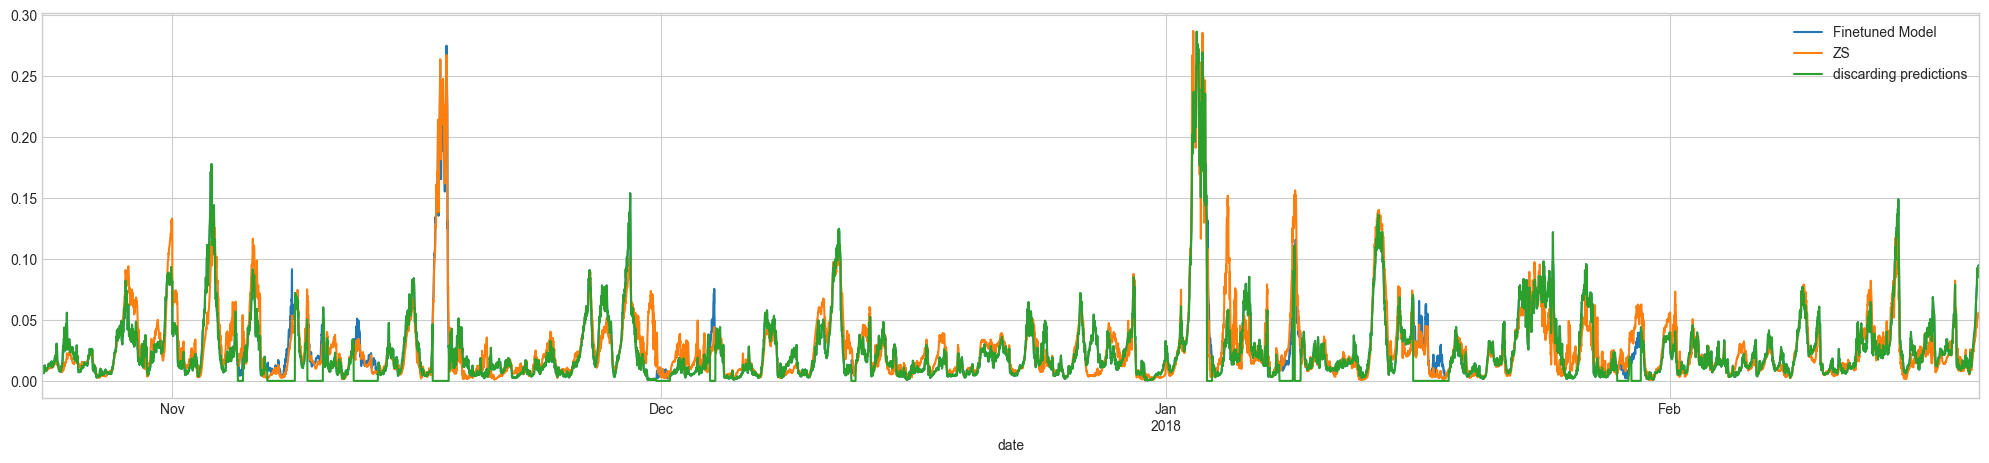

In [67]:
# ax8 = targeted_shap_df.plot(
#     x="date",
#     y="error",
#     figsize=(25, 5),
#     label="Targeted-shap Model",
#     title="Error per sample on the test set using finetuned and targeted(shap) models"
# )


ax8 = fft_test_df.plot(
    x="date",
    y="error",
    figsize=(25, 5),
    # ax=ax8,         
    label="Finetuned Model"
)

zs_test_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="ZS"
)

discard_df.plot(
    x="date",
    y="error",
    ax=ax8,
    label="discarding predictions"




)


### Next Steps 
- Check similarity with test samples and discard samples based on average similarity on validation set.
- Cross check if the predictions for discarded test samples were greater than average zero shot error.

In [64]:
drop_limit = int(0.1 * len(dset_test))
print("Allowed number of samples to discard predictions", drop_limit)

Allowed number of samples to discard predictions 1142


### Using FastDTW metric

In [ ]:
# Comparing shapelets to test set samples based on distance similarity to discard predictions 

test_distances = np.zeros((len(dset_test),len(shapelet_dict_v3)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(shapelet_dict_v3.values()):
        dist = fastdtw(dset_test[i]["past_values"], shapelet)[0]
        test_distances[i, j] = dist      


Allowed number of samples to discard predictions 278


### Using Euclidean Distance metric

In [50]:
len(select_shapelets_v7)

25

In [51]:
def z_norm(x):
    return (x - np.mean(x)) / np.std(x)

def shapelet_distance(segment, series):
    seg = z_norm(segment)
    series = z_norm(series)
    seg_len = len(seg)
    return min(np.linalg.norm(seg - series[i:i+seg_len]) for i in range(len(series)-seg_len+1))


test_distances_ed = np.zeros((len(dset_test),len(select_shapelets_v7)))

# save all the test distances with shapelets in an array
for i in range(len(dset_test)):
    for j, shapelet in enumerate(select_shapelets_v7.values()):
        series = np.array(dset_test[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        test_distances_ed[i, j] = dist

In [52]:
pd.DataFrame(test_distances_ed)

0         1         2         3         4         5         6   \
0      4.970538  9.193727  5.263893  6.649495  5.709728  8.492747  7.681191   
1      4.972827  9.190281  5.265894  6.651115  5.711707  8.493665  7.675517   
2      4.977414  9.183292  5.269770  6.654323  5.715518  8.495436  7.664056   
3      4.982959  9.175223  5.274818  6.658307  5.720542  8.306177  7.650654   
4      4.986143  9.169989  5.277015  6.660392  5.722609  8.132613  7.642259   
...         ...       ...       ...       ...       ...       ...       ...   
11420  5.954864  9.433311  5.687506  9.341636  5.855215  7.775511  6.196787   
11421  5.987705  9.431684  5.661155  9.396582  5.873855  7.829673  6.216744   
11422  6.022947  9.430330  5.634644  9.454002  5.894459  7.886519  6.238610   
11423  6.059870  9.429227  5.608717  9.512298  5.916811  7.944585  6.262089   
11424  6.094888  9.428832  5.585057  9.567975  5.937232  7.999715  6.284178   

             7         8         9   ...        15        16        17  \
0      6.596627  5.333659  6.561499  ...  6.968773  7.051642  6.679059   
1      6.600010  5.335838  6.562775  ...  6.971738  7.047142  6.676499   
2      6.606766  5.340186  6.565287  ...  6.977652  7.038081  6.671361   
3      6.614916  5.345485  6.568459  ...  6.984806  7.027431  6.665325   
4      6.619559  5.348444  6.570035  ...  6.988851  7.020897  6.661653   
...         ...       ...       ...  ...       ...       ...       ...   
11420  6.114181  5.610229  8.374195  ...  7.277709  5.235905  7.597409   
11421  6.108449  5.662445  8.408897  ...  7.259964  5.246686  7.582808   
11422  6.103558  5.717706  8.445532  ...  7.241995  5.259307  7.568053   
11423  6.099905  5.774736  8.483128  ...  7.223953  5.273750  7.553144   
11424  6.096465  5.828608  8.519207  ...  7.208894  5.287510  7.541265   

             18        19        20        21        22        23        24  
0      9.601949  7.559423  7.955694  8.606757  4.534878  5.813067  7.729127  
1      9.603201  7.561933  7.951899  8.603332  4.531394  5.812494  7.731688  
2      9.605659  7.566924  7.944220  8.596392  4.524442  5.811407  7.736775  
3      9.608751  7.573008  7.935306  8.588357  4.516152  5.810026  7.742990  
4      9.610285  7.576363  7.929620  8.583191  4.511357  5.809458  7.746385  
...         ...       ...       ...       ...       ...       ...       ...  
11420  8.188385  7.083839  5.686692  5.855512  8.057233  9.491760  5.843751  
11421  8.185107  7.064526  5.660526  5.862967  8.107442  9.479362  5.849179  
11422  8.182190  7.044958  5.634192  5.871928  8.160218  9.466600  5.856031  
11423  8.179561  7.025339  5.608377  5.882455  8.214325  9.453390  5.864427  
11424  8.178284  7.008756  5.585031  5.892395  8.265250  9.442918  5.872345  

[11425 rows x 25 columns]

In [65]:
import warnings

min_dists = test_distances_ed.min(axis=1)
sorted_idx = np.argsort(min_dists)
samples_to_drop = sorted_idx[:drop_limit]

# models_to_use = ["v"]

total_error = []

for i in range(len(dset_test)):
    if i in samples_to_drop:
        # print("Discarding the sample as due to high similarity with one of the shapelets")
        dis = 0
        total_error.append(dis)

    else:
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            preds_dict = fft_trainer.predict([dset_test[i]])
            
            preds = preds_dict.predictions[0]
            preds = preds.squeeze(0)
            
            actual = np.array(dset_test[i]["future_values"])
            error = mean_squared_error(preds, actual)
            # print("error directly from index 2", preds_dict[2]["test_loss"])
            total_error.append(error)

# Error after discarding allowed unreliable predictions
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))
discard_df = pd.DataFrame(total_error, columns=["error"])
discard_df['date'] = zs_test_df["date"]



Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.022863497218510432


In [66]:
print("Average error after discarding 10\% of the predictions due to close matches with shapelets: ", np.mean(total_error))

Average error after discarding 10\% of the predictions due to close matches with shapelets:  0.022863497218510432


In [506]:
val_distances_ed = np.zeros((len(dset_val),len(shapelet_dict_v3)))

# save all the test distances with shapelets in an array
for i in range(len(dset_val)):
    for j, shapelet in enumerate(shapelet_dict_v3.values()):
        series = np.array(dset_val[i]["past_values"].squeeze(1))
        dist = shapelet_distance(shapelet, series)
        val_distances_ed[i, j] = dist

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

dataset_path = "https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTm1.csv"

data = pd.read_csv(
    dataset_path,
    parse_dates=[timestamp_column],
)
# data
columns_to_drop = ["HUFL", "HULL", "MUFL", "MULL", "LUFL", "LULL"]
data = data.drop(columns=columns_to_drop)
train_data = data[0:34560]
val_data = data[34560:46080]
test_data = data[46080:57600]

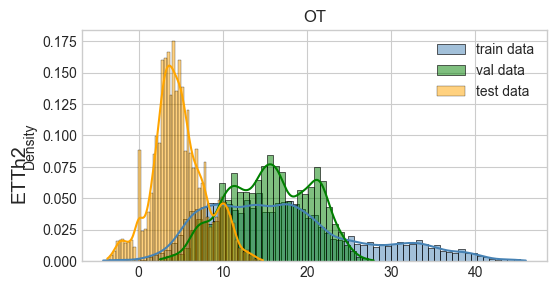

In [63]:
col = "OT"

plt.figure(figsize=(6, 3))
sns.histplot(train_data[col], color='steelblue', kde=True,
             stat='density', alpha=0.5, label='train data')
sns.histplot(val_data[col], color='green', kde=True,
             stat='density', alpha=0.5, label='val data')
sns.histplot(test_data[col], color='orange', kde=True,
             stat='density', alpha=0.5, label='test data')
plt.legend()
plt.xlabel('')
plt.ylabel('Density')
plt.title(col)
plt.suptitle("ETTh2", fontsize=14, x=0.02, y=0.5, rotation=90)
# plt.tight_layout()
plt.show()